In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import calendar
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest


In [122]:
customer_data = pd.read_csv("loyalty.csv")
print(customer_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1246 entries, 0 to 1245
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_id           1246 non-null   int64  
 1   spend                 1246 non-null   float64
 2   first_month           1246 non-null   object 
 3   items_in_first_month  1246 non-null   int64  
 4   region                1246 non-null   object 
 5   loyalty_years         1246 non-null   object 
 6   joining_month         1121 non-null   object 
 7   promotion             1246 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 78.0+ KB
None


# **Checking the data columns by column**  
First I am checking the data accordingly to what we should expect.
## **customer_id**  
All the values should be unique.  


In [123]:
print(len(customer_data["customer_id"].unique()))
len(customer_data)

1246


1246

In [124]:
print(customer_data["customer_id"].iloc[-1])

1246


The dataframe is ordered by the ascending customer_id.  

## **spend**  
Continuous. </br>The total spend of the customer in their last full year. This can be any positive value to two decimal places. </br>Missing values should be replaced with 0. 

In [125]:
print(customer_data["spend"].describe())
print(customer_data["spend"].head())

count    1246.000000
mean      122.637119
std         9.975102
min       104.290000
25%       112.210000
50%       123.840000
75%       131.092500
max       142.290000
Name: spend, dtype: float64
0    132.68
1    106.45
2    123.16
3    130.60
4    130.41
Name: spend, dtype: float64


There are no missing values and no 0 (the minimum is 104.29).  
Furthermore, it seems that the values are all rounded to 2 decimals. However, the 75 percentile has 4 decimals. Because I am a bit lazy, just to be sure I will round to 2 decimals the column.  


In [126]:
customer_data["spend"] = customer_data["spend"].round(2)

## **first_month**  
Continuous. </br>The amount spent by the customer in their first month of the year. This can be any positive value, rounded to two decimal places. </br>Missing values should be replaced with 0.  

Based on the general info, this column is an object type (string). It should be a float.  

In [127]:
print(customer_data["first_month"].value_counts(dropna=False))
print(customer_data["first_month"].isna().sum())

first_month
.        125
21.38     12
21.33     10
21.35      9
21.39      9
        ... 
15.71      1
25.28      1
24.41      1
19.95      1
26.18      1
Name: count, Length: 491, dtype: int64
0


The problem is the ".". I will replace it to 0 and change to float type.

In [128]:
customer_data["first_month"].replace(".",None, inplace=True)
customer_data["first_month"] = customer_data["first_month"].astype(float)
customer_data["first_month"].fillna(0, inplace=True)
print(customer_data["first_month"].describe())

count    1246.000000
mean       17.161998
std         6.583749
min         0.000000
25%        15.750000
50%        19.125000
75%        21.280000
max        26.200000
Name: first_month, dtype: float64


C:\Users\Angelique\AppData\Local\Temp\ipykernel_15300\2959011451.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_data["first_month"].replace(".",None, inplace=True)
C:\Users\Angelique\AppData\Local\Temp\ipykernel_15300\2959011451.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

In [129]:
customer_data["first_month"] = customer_data["first_month"].round(2)
print(customer_data["first_month"].describe())

count    1246.000000
mean       17.161998
std         6.583749
min         0.000000
25%        15.750000
50%        19.125000
75%        21.280000
max        26.200000
Name: first_month, dtype: float64


## **items_in_first_month**
Discrete. </br>The number of items purchased in the first month. Any integer value greater than or equal to zero. </br>Missing values should be replaced by 0.  

Based on the general info, the type is integer so it's a good type. Furthermore there are no missing values. So let's see if we have 0. If we do not have 0, I will have to compare with the customers who have spent nothing in the first month.  

In [130]:
print(customer_data["items_in_first_month"].describe())

count    1246.000000
mean        9.418138
std         3.000288
min         5.000000
25%         7.000000
50%         9.000000
75%        13.000000
max        15.000000
Name: items_in_first_month, dtype: float64


Humm...We do not have any 0 as minimum. I will go back to it in the next chapter. For now I am only doing a general scrolling.  

## **region**
Nominal. </br>The geographic region that the customer is based in. One of four values Americas, Asia/Pacific, Europe, Middle East/Africa. </br>Missing values should be replaced with "Unknown".  
In the general info this column is an object. So far so good.  

In [131]:
print(customer_data["region"].value_counts(dropna=False))

region
Middle East/Africa    326
Europe                320
Americas              309
Asia/Pacific          291
Name: count, dtype: int64


Everything seems in Ordnung. So I will switch to categorical to gain some space.  

In [132]:
customer_data["region"] = customer_data["region"].astype("category")

## **loyalty_years**  
Oridinal. </br>The number of years the customer has been a part of the loyalty program. One of five ordered categories, '0-1', '1-3', '3-5', '5-10', '10+'. </br>Missing values should be replaced with '0-1'.  
Right now the column is an object and needs to be changed into an ordered caetgorical type.  

In [133]:
print(customer_data["loyalty_years"].value_counts(dropna=False, sort=False))

loyalty_years
5-10    250
0-1     382
10+     117
3-5     256
1-3     241
Name: count, dtype: int64


I have to switch to categories. Right now they are not ordered at all.  

In [134]:
customer_data["loyalty_years"] = customer_data["loyalty_years"].astype("category")
new_categories = ["0-1","1-3","3-5","5-10","10+"]
customer_data["loyalty_years"] = customer_data["loyalty_years"].cat.reorder_categories(new_categories=new_categories, ordered=True)
print(customer_data["loyalty_years"].value_counts(sort=False))

loyalty_years
0-1     382
1-3     241
3-5     256
5-10    250
10+     117
Name: count, dtype: int64


## **joining_month**  
Nominal. </br>The month the customer joined the loyalty program. One of 12 values "Jan", "Feb", "Mar", "Apr", etc. </br>Missing values should be replaced with "Unknown".  

In [135]:
#joining_month_num will be used for modelisation
customer_data["joining_month_num"] = pd.to_datetime(customer_data["joining_month"], format="%b")
customer_data["joining_month_num"] = customer_data["joining_month_num"].dt.month
customer_data["joining_month_num"].fillna(0, inplace=True)

customer_data["joining_month"].fillna("Unknown", inplace=True)
ordered_month = ['Unknown', "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
customer_data["joining_month"] = customer_data["joining_month"].astype("category")
customer_data["joining_month"] = customer_data["joining_month"].cat.reorder_categories(new_categories=ordered_month\
                                                                                       , ordered=True)

print(customer_data["joining_month"].value_counts(sort=False, dropna=False))
print(customer_data["joining_month_num"].value_counts(dropna=False))


joining_month
Unknown    125
Jan        146
Feb        109
Mar         85
Apr         93
May         96
Jun         75
Jul        111
Aug         91
Sep         88
Oct        107
Nov         75
Dec         45
Name: count, dtype: int64
joining_month_num
1.0     146
0.0     125
7.0     111
2.0     109
10.0    107
5.0      96
4.0      93
8.0      91
9.0      88
3.0      85
11.0     75
6.0      75
12.0     45
Name: count, dtype: int64


C:\Users\Angelique\AppData\Local\Temp\ipykernel_15300\247947896.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_data["joining_month_num"].fillna(0, inplace=True)
C:\Users\Angelique\AppData\Local\Temp\ipykernel_15300\247947896.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 

## **promotion**
Nominal. </br>Did the customer join the loyalty program as part of a promotion? Either 'Yes' or 'No'. </br>Missing values should be replaced with 'No'.

In [136]:
print(customer_data["promotion"].value_counts(dropna=False))

promotion
No     572
Yes    549
NO      63
YES     62
Name: count, dtype: int64


We have some typo problems. Let's clean this up.

In [137]:
customer_data["promotion"] = customer_data["promotion"].str.title()
print(customer_data["promotion"].value_counts())

promotion
No     635
Yes    611
Name: count, dtype: int64


# **A closer look to our customers who got free items at their first month (reward)**  
10% of our customers have spent nothing in their 1st month of the year although they did buy stuffs since I do not have 0 items bought in the first month.  
the question we can therefore ask is: do these customers who spent nothing in their first month but only used their rewards, spend in this year more than the ones who did spend some money in their first month?
It would make sense that if they are satisfied with the reward, having bought so many things for free, they would spend more during the year, encouraged to get a bigger reward and therefore more free stuffs for them the following year. 


## **Do the customers who bought stuff only with their rewards on their first month, spend more over the year?**  
We can see that these customers who have spent nothing on their renewal month and only took advantage of their rewards, got a fair number of items for free.  
I think therefore that it is legitimate to analyse their spending behaviour over the year compared to the customers who did spend some money on the month of their membership renewal. 

In [138]:
customer_data["rewarded_vs_not"] = np.where(customer_data["first_month"] == 0, "rewarded", "invested")
print(customer_data.groupby("rewarded_vs_not")["spend"].describe())

                  count        mean        std     min     25%     50%  \
rewarded_vs_not                                                          
invested         1121.0  122.575513  10.034816  104.29  112.19  123.84   
rewarded          125.0  123.189600   9.443026  104.50  112.50  124.73   

                    75%     max  
rewarded_vs_not                  
invested         130.99  142.29  
rewarded         131.18  141.85  


I don't see much difference between the people who took advanatge of their rewards and the ones who haven't. I can make a quick statistical test (just to show off) to see if that's the case (H0 = no difference of year spend).  

<Axes: xlabel='spend', ylabel='Count'>

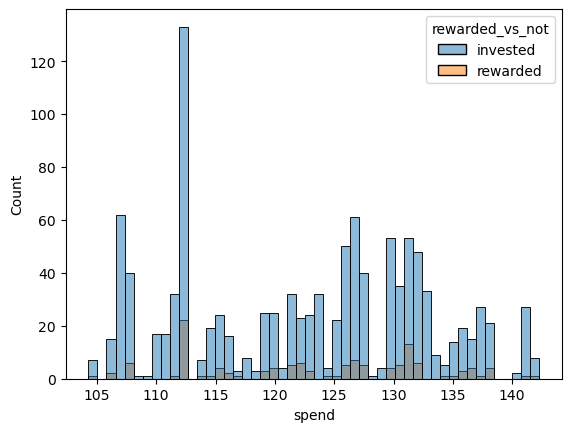

In [139]:
#look at the distribution of spend
sns.histplot(x="spend", data=customer_data, hue="rewarded_vs_not", bins=50)

The spending is not normally distributed, so I will use a non parametric statiscal test. Because I am comparing only 2 samples, I will use a Mann-Whitney U test.

In [140]:
alpha = 0.05
spend_U_stat, spend_U_pval = mannwhitneyu(customer_data[customer_data["rewarded_vs_not"] == "rewarded"]["spend"],\
                                          customer_data[customer_data["rewarded_vs_not"] == "invested"]["spend"])
print(f"Mann-Whitney U test p_val: {spend_U_pval:0.4f}")

Mann-Whitney U test p_val: 0.4679


There is no significant difference of the amount spend over the year between the people who took fully advantage of their rewards and the ones who haven't.  
Perhaps the ones who did spend some money on their renewal month bought more items which would have included the free ones plus others.  

## **Do the customers who spent some money on their first month, buy more items in that month?**  
The idea here is that if these customers who do not spend more than the others over a year use all their reward on their first month, they may get less items than the ones who have spent somemoney on their first month.  

In [141]:
print(customer_data.groupby("rewarded_vs_not")["items_in_first_month"].describe())

                  count      mean       std  min  25%  50%   75%   max
rewarded_vs_not                                                       
invested         1121.0  9.443354  3.025878  5.0  7.0  9.0  13.0  15.0
rewarded          125.0  9.192000  2.761183  5.0  7.0  9.0  11.0  14.0


Once again, I do not see any significant differences (the median is exactly the same between the two groups) between the two groups.

<Axes: xlabel='rewarded_vs_not', ylabel='items_in_first_month'>

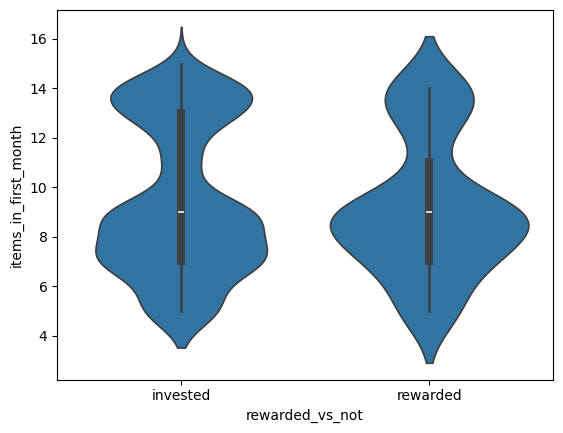

In [142]:
sns.violinplot(x="rewarded_vs_not", y="items_in_first_month", data=customer_data)

The violin plot shows the same subdivision between our two populations. As shown in the table, the median is exactly the same. However, among the minorities who bought more than 10 items, the population seems slightly larger in the invested customers (the ones who did spend some money on their first month). Question would be therefore to test whether the proportion of n_items > 10 in the "invested" subpopulation is significantly higher than the one in the "rewarded" subpopulation. 
I will do a proportion test.  
H0 = the proportion of items > 10 is the same between rewarded and invested.  
H1 = the proportion of items > 10 in the rewarded population is lower than in the invested.  
alpha = 0.05

In [143]:
customer_data["big_items_nb"] = np.where(customer_data["items_in_first_month"] > 10, ">10", "<10")
p_hats = customer_data.groupby("rewarded_vs_not")["big_items_nb"].value_counts(normalize = True)
print(p_hats)
n_big_small_items = customer_data.groupby("rewarded_vs_not")["big_items_nb"].value_counts()
print(n_big_small_items)
n_more_10 = np.array([397, 34])
n_rows = np.array([724+397, 91+34])
z_score,p_value = proportions_ztest(count=n_more_10, nobs=n_rows, alternative="larger")
print(z_score, p_value)

rewarded_vs_not  big_items_nb
invested         <10             0.645852
                 >10             0.354148
rewarded         <10             0.728000
                 >10             0.272000
Name: proportion, dtype: float64
rewarded_vs_not  big_items_nb
invested         <10             724
                 >10             397
rewarded         <10              91
                 >10              34
Name: count, dtype: int64
1.8314574062017945 0.03351614982201288


with an alpha=0.05 I can reject H0 and conclude that the proportion of people buying more than 10 items in their first month is higher in the invested population compared to the rewarded (the ones who bought stuff only with their reward).  
However, the difference is very small (0.354 vs 0.272). Some improvements should be done to encourage the customers to use their rewards AND buy stuff with real money.  

# **Does loyalty pay off (to our advantage of course)?**
The team at International Essentials have told me that they have always believed that the number of years in the loyalty scheme is the biggest driver of spend.  
Let's see if they have a good instinct.  

In [144]:
print(customer_data.groupby("loyalty_years")["spend"].describe())

               count        mean       std     min       25%      50%  \
loyalty_years                                                           
0-1            382.0  110.557461  3.050032  104.29  107.5625  111.815   
1-3            241.0  129.308340  3.106174  123.66  126.5200  130.200   
3-5            256.0  124.550547  3.329429  119.16  121.6975  125.110   
5-10           250.0  135.150040  3.755654  129.75  132.2400  135.565   
10+            117.0  117.411453  4.089553  111.88  114.1000  117.680   

                    75%     max  
loyalty_years                    
0-1            112.1775  118.36  
1-3            131.5700  137.47  
3-5            127.0625  131.34  
5-10           137.7375  142.29  
10+            119.9900  124.26  


C:\Users\Angelique\AppData\Local\Temp\ipykernel_15300\3689172978.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(customer_data.groupby("loyalty_years")["spend"].describe())


<Axes: xlabel='loyalty_years', ylabel='spend'>

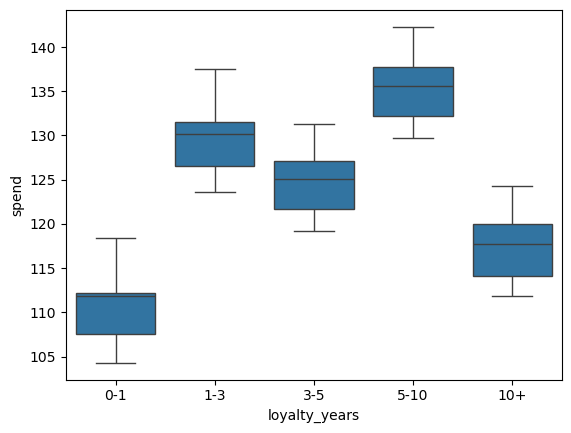

In [145]:
sns.boxplot(x="loyalty_years", y="spend", data=customer_data)

I need to test whether there is a trend: the longer you're loyal, the more you spend. When I am looking at it, it seems to be true up to a certain point. After 10 years of loyalty we can a certain "fatigue" from our customers.  

# **Does the amount spent depends on when you started your membership?**

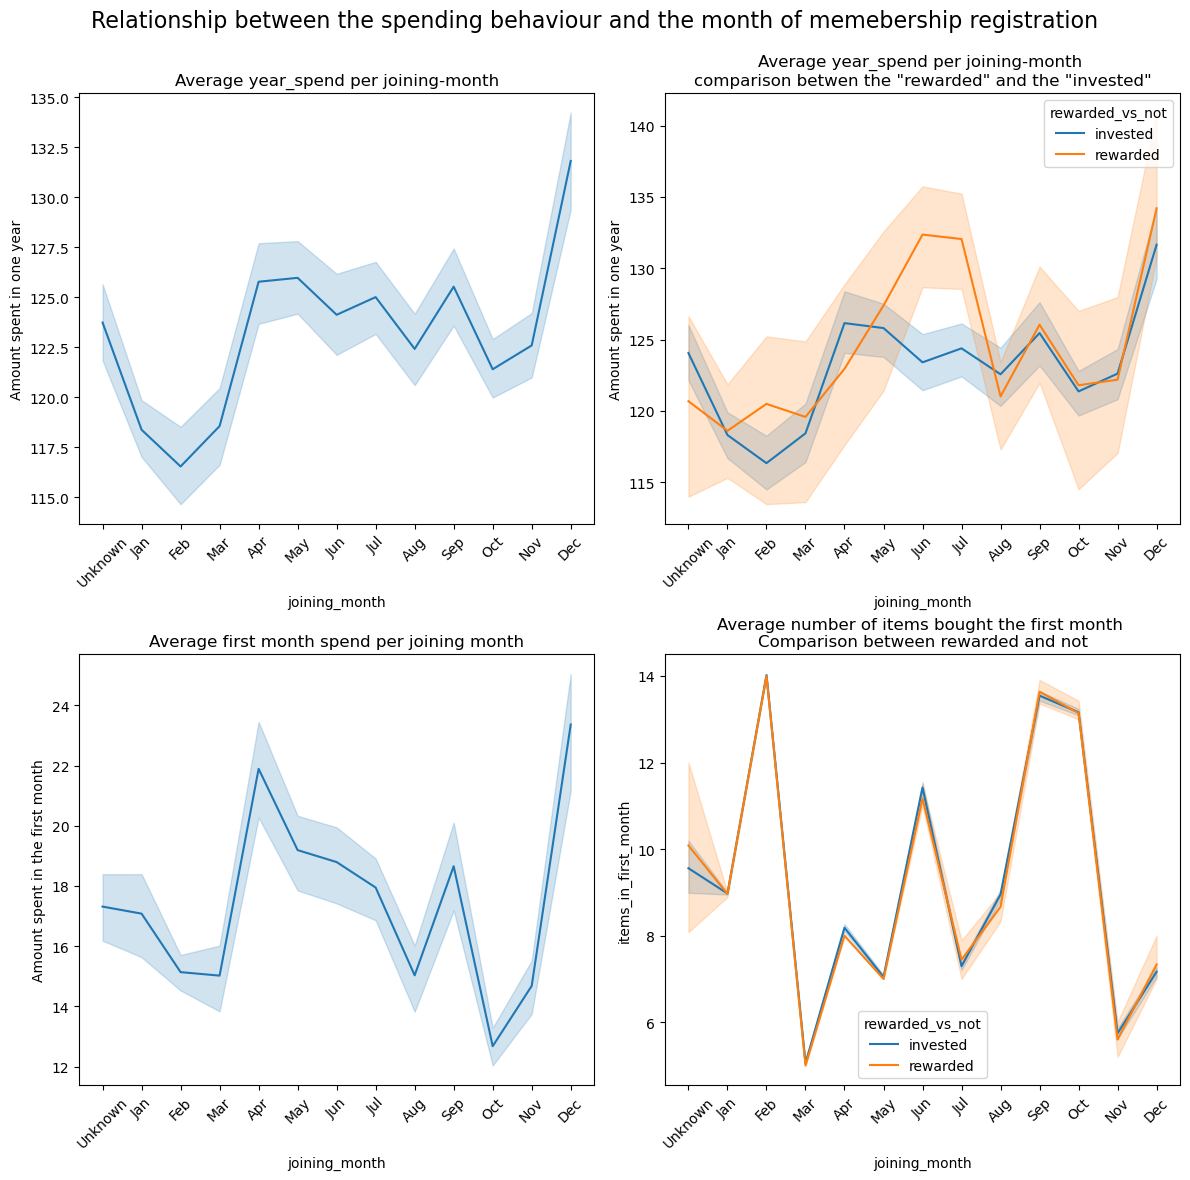

In [166]:
fig,axes = plt.subplots(2,2, figsize=(12,12))
sns.lineplot(x="joining_month", y="spend", data=customer_data, ax=axes[0,0])
sns.lineplot(x="joining_month", y="spend", data=customer_data, hue="rewarded_vs_not", ax=axes[0,1])
axes[0,0].set_title("Average year_spend per joining-month")
axes[0,1].set_title('Average year_spend per joining-month \ncomparison betwen the "rewarded" and the "invested"' )
axes[0,0].set_ylabel("Amount spent in one year")
axes[0,1].set_ylabel("Amount spent in one year")
axes[0,0].tick_params(axis="x", rotation=45)
axes[0,1].tick_params(axis="x", rotation=45)
sns.lineplot(x="joining_month", y="first_month", data=customer_data, ax=axes[1,0])
axes[1,0].set_title("Average first month spend per joining month")
axes[1,0].set_ylabel("Amount spent in the first month")
axes[1,0].tick_params(axis="x", rotation=45)
sns.lineplot(x="joining_month", y="items_in_first_month", data=customer_data, hue="rewarded_vs_not", ax=axes[1,1])
axes[1,1].set_title("Average number of items bought the first month \nComparison between rewarded and not")
axes[1,1].tick_params(axis="x", rotation=45)
plt.tight_layout()
fig.suptitle("Relationship between the spending behaviour and the month of memebership registration", fontsize=16)
plt.subplots_adjust(top=0.91)
plt.show()


<Axes: xlabel='joining_month', ylabel='spend'>

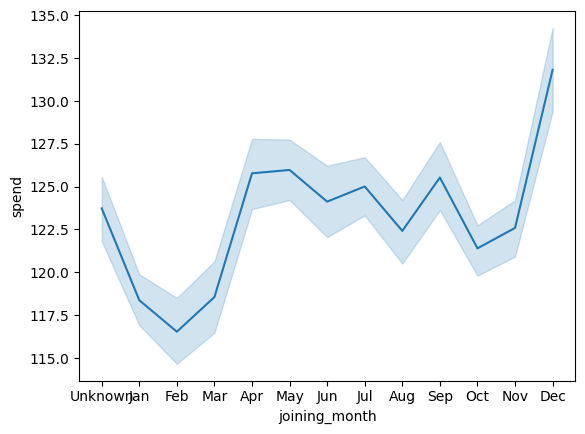

In [156]:
sns.lineplot(x="joining_month", y="spend", data=customer_data)

Interestingly, it seems the period of the year customers join the loyalty membership influences their spending behaviour over the year. 

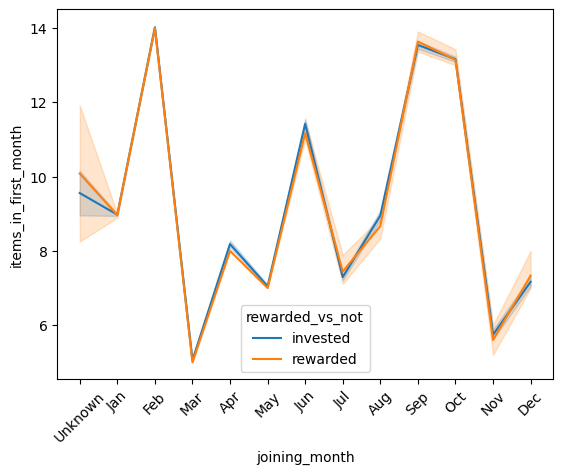

In [155]:
sns.lineplot(x="joining_month", y="items_in_first_month", hue="rewarded_vs_not", data=customer_data)
plt.xticks(rotation=45)
plt.show()

A lot of info here.  
Overall, the customers who are spending the most in their full membership year are the ones who joined "the club" in December. This makes sense. In December we have two big festive events: christmas and New Year's eve. And February is clearly a "doomed" month to join the loyalty membership. People who start their membership year in February are the ones who spend the least in their year.  
Interestingly however, if we look more specifically at the customers who make the best of their reward card (meaning that they do not pay a dime at their anniversary membership), we can see that the ones who took their membership in summer (June-July) spend similarly as the customers who joined in December. It would be interesting to check why is that.  
Fun to note but I'm not sure that relevant for us, people spend a lot in december but invest more in expensive stuff as the number of items bought is very low and the reward cannot cover their expense. when we compare to June for example, people can get tons of stuff with their rewards.  
Obviously all these statement wil have to be confirmed statistically speaking.  
But before, I will take a look at the behavour of the customers depending on the region. Inded, Easter is a big thing in Europe (April) but not so much in Asia for example. And although Coca-Cola mondialised christmas it is perhaps still not a big thing in non-christian countries (the Middle East/Africa region is to me a bit too large as in Africa you have many christian countries as well as muslim).